### Libraries

In [22]:
import cartopy.crs as ccrs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import pystac_client
import xarray as xr
import geopandas as gpd

In [23]:
planetary_computer.set_subscription_key("c27669c4bdec434d804e2bd738cb16fc")
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
print(catalog)

<Client id=microsoft-pc>


### Gather User Input

Assumptions:
1. User can input coordinates that respresent a region of interest ROI
2. User can input names for common locations (countries, cities, states etc)
3. The shape of the user input will be a four sided polygon (for now do not worry about multisided polygons)

In [24]:
longitude = 79.109
latitude = 22.746

geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

### Data query

In [25]:
search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-04-02/2023-04-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "ch4"}},
)

items = list(search.get_items())

print(f"Found {len(items)} items:")

for item in search.items():
    print(item.id)

c:\Users\Joshua\AppData\Local\Programs\Python\Python311\Lib\site-packages\pystac_client\item_search.py:831: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Found 2 items:
S5P_L2_CH4____20230403T063304_20230403T081434_28345
S5P_L2_CH4____20230402T065156_20230402T083327_28331


### Reading and Processing Data

In [26]:
# Read data
f = fsspec.open(items[0].assets["ch4"].href).open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf") # Putting the data into a xarray dataset
ds

### Plot Base Map

C:\Users\Joshua\AppData\Local\Temp\ipykernel_17636\2245535688.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

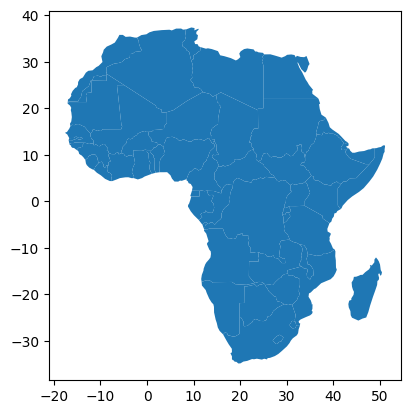

In [30]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
australia = world[world['continent'] == 'Africa']
australia.plot()

### Plot Concentration Values

### Time Series

In [31]:
varname = "methane_mixing_ratio_bias_corrected"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="viridis")

NameError: name 'ds' is not defined

/opt/homebrew/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


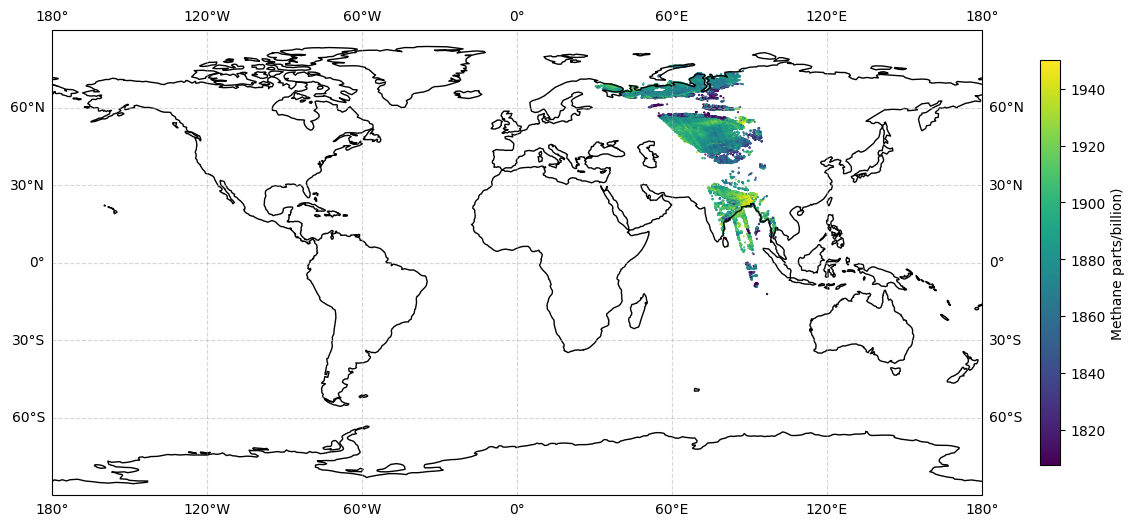

In [ ]:
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
methane = data.values

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scatter = plt.scatter(
    lon,
    lat,
    c=methane,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    norm=norm,
    marker=".",
    s=1,
)
fig.colorbar(scatter, pad=0.05, shrink=0.35, label="Methane parts/billion)")
plt.show()